# Выбор локации для скважины

Добывающей нефтяной компании нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски с помощью *Bootstrap*.

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline

from scipy import stats as st

### Импорт датасетов

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

### Предобработка и анализ данных 

In [3]:
def info(df):
    display(df.sample(5))
    display(df.describe())
    display(df.info())

def prep(df):
    print(f'Количество полных дубликатов в датасете:', df.duplicated().sum())
    df = df.drop_duplicates()
    print()
    print(f'Количество неполных дубликатов в датасете:', df.drop('id', axis = 1).duplicated().sum())
    print()
    print(f'Количество пропусков в датасете:\n', df.isna().sum())
    df = df.dropna()
    print()
    
    
def hist(df):
    for col in df.drop('id', axis = 1).columns:
        plt.figure()
        plt.title(str(col) + ' hist')
        plt.xlabel(col)
        df[col].hist()
        plt.show()
        plt.figure()
        plt.title(str(col) + ' boxplot')
        plt.boxplot(df[col])
        plt.xlabel(col)
        plt.show()


def scatter(df):
    for col in df.drop(['id', 'product'], axis = 1).columns:
        plt.figure(figsize = (16,9))
        plt.title(str(col) + ' vs ' + 'product')
        plt.xlabel(col)
        plt.ylabel('product')
        plt.scatter(x = df[col], y = df['product'], alpha = 0.7, s = 1)
        plt.show()
    
    
    

def corr(df):
    plt.figure()
    sns.heatmap(df.corr(method = 'spearman'), annot=True)
    plt.show()
    
    
    
def full_an(df):
    print('Вывод датасетов')
    info(df)
    print()
    print()
    print()
    print('Предподготовка данных')
    prep(df)
    print()
    print()
    print()
    print('Исследовательский анализ данных')
    hist(df)
    print()
    print()
    print()
    print('Диаграммы рассеяния')
    scatter(df)
    print()
    print()
    print()
    print('Корреляционный анализ данных')
    corr(df)
    print()
    print()
    print()

Вывод датасетов


id        f0        f1        f2    product
91361  kKNQR  1.447329 -0.512998 -5.872151  82.191273
52379  UDtCT -0.306560  0.923912  9.855868  93.728713
19901  udWDe -0.880950  0.759942  0.656192  40.766410
22927  fCeRt  0.480574 -0.443625  4.094098  50.111423
72426  OORIb  0.958639  0.163724 -0.612556  61.645736

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None




Предподготовка данных
Количество полных дубликатов в датасете: 0

Количество неполных дубликатов в датасете: 0

Количество пропусков в датасете:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64




Исследовательский анализ данных


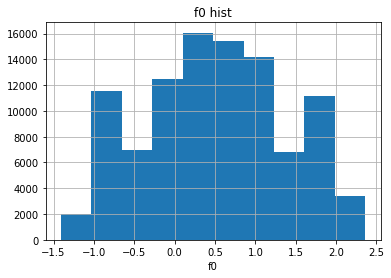

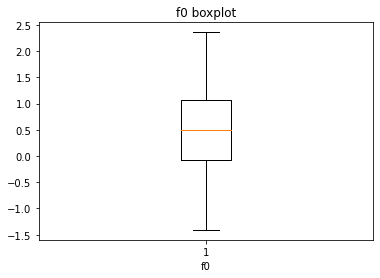

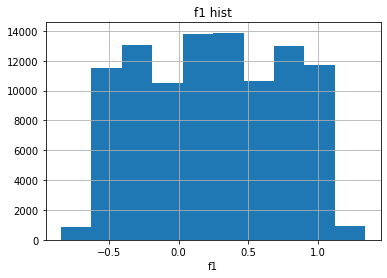

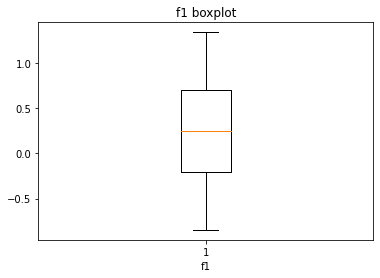

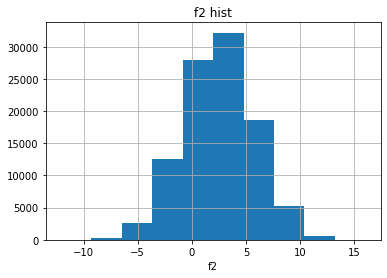

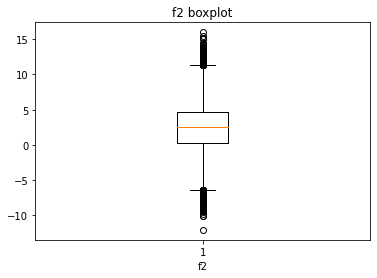

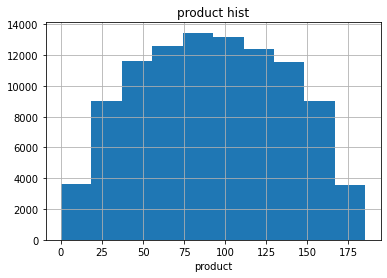

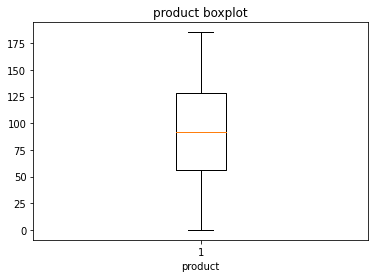




Диаграммы рассеяния


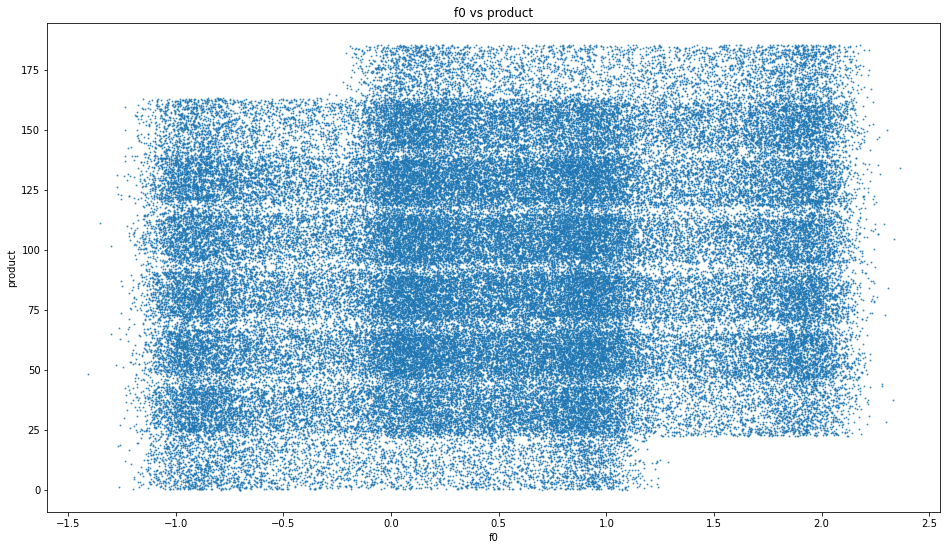

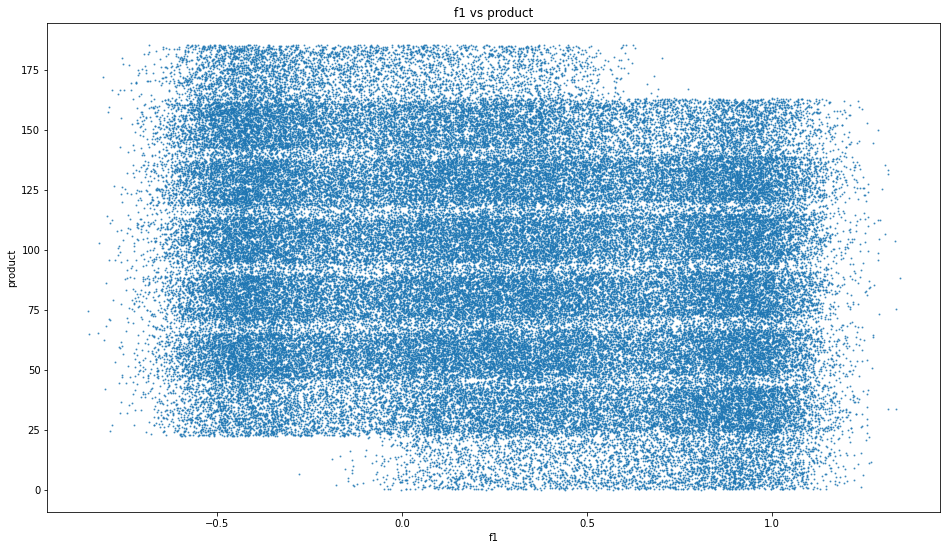

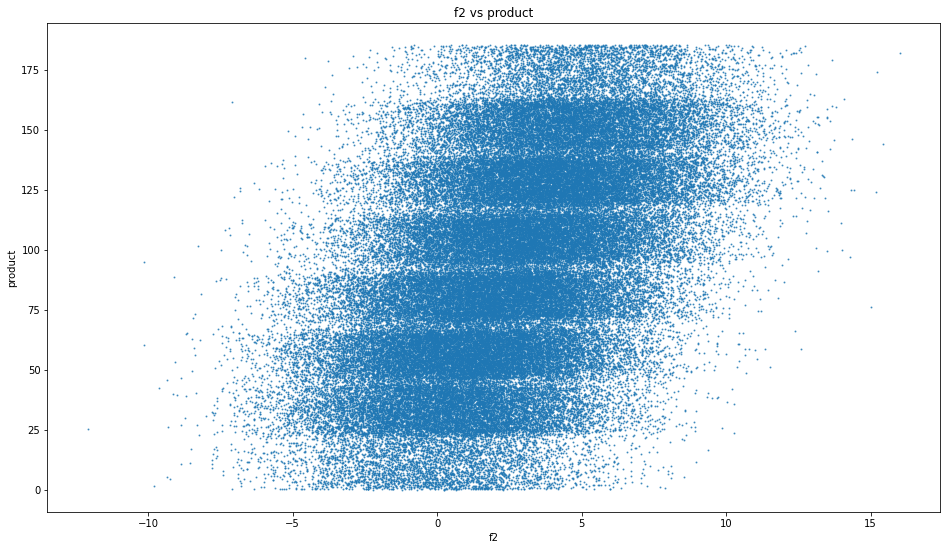




Корреляционный анализ данных


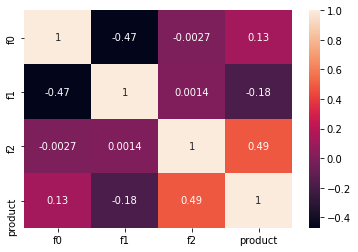

In [4]:
# Анализ df0
full_an(df0)

Вывод датасетов


id        f0         f1        f2     product
4219   qhA9d -5.782398   3.175051  1.999332   57.085625
47139  vfMiv -2.192676  -0.359421  0.004019    3.179103
19615  CxdYZ -9.316816  -5.095310  3.999583  110.992147
63483  maKG7 -8.019949 -10.045395  4.000672  110.992147
23320  iN5JV  7.228221  -3.150774  3.999029  107.813044

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None




Предподготовка данных
Количество полных дубликатов в датасете: 0

Количество неполных дубликатов в датасете: 0

Количество пропусков в датасете:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64




Исследовательский анализ данных


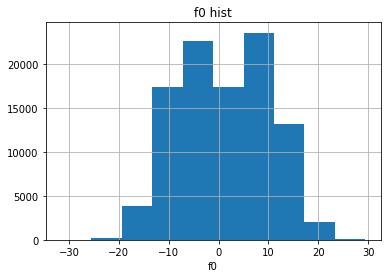

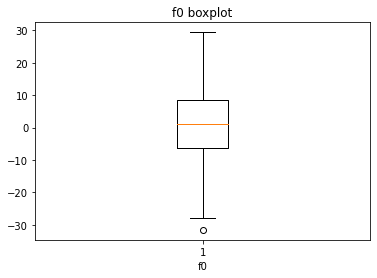

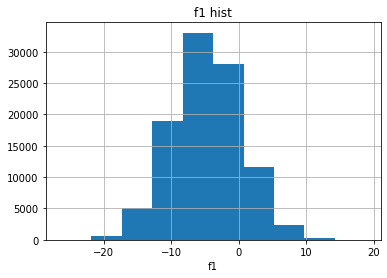

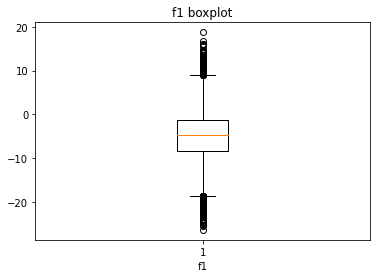

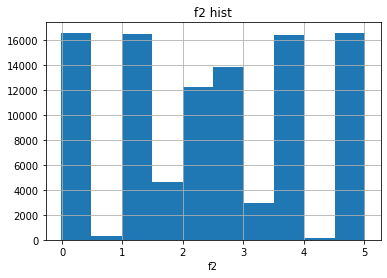

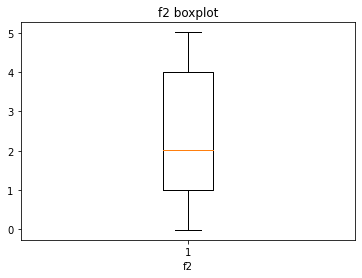

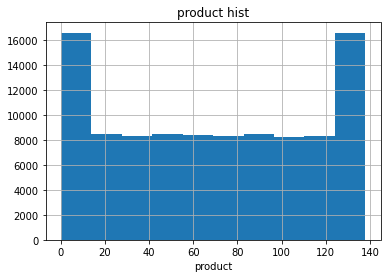

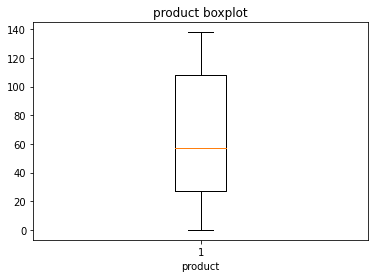




Диаграммы рассеяния


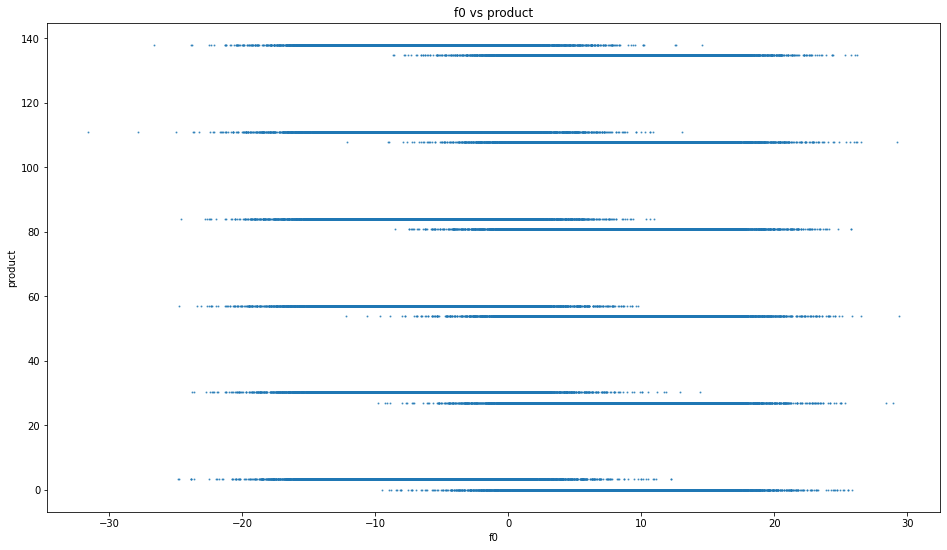

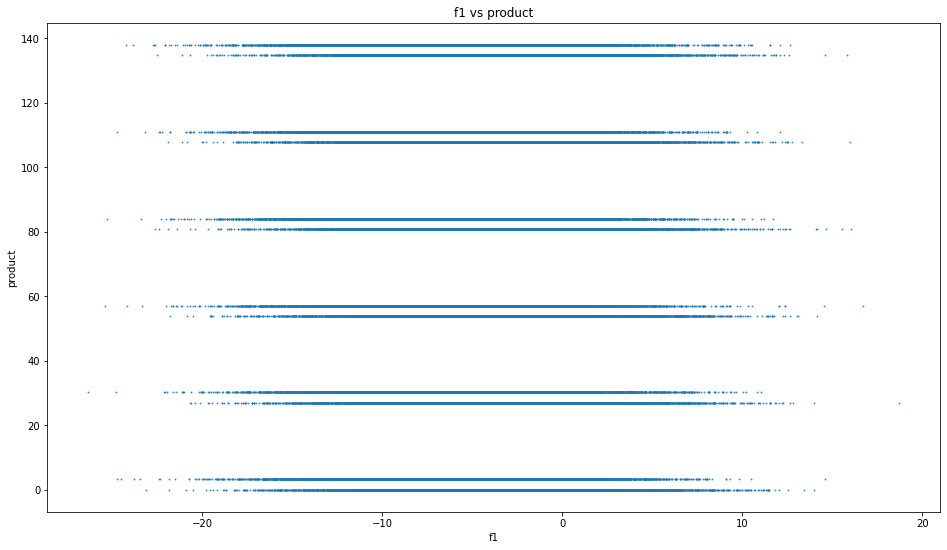

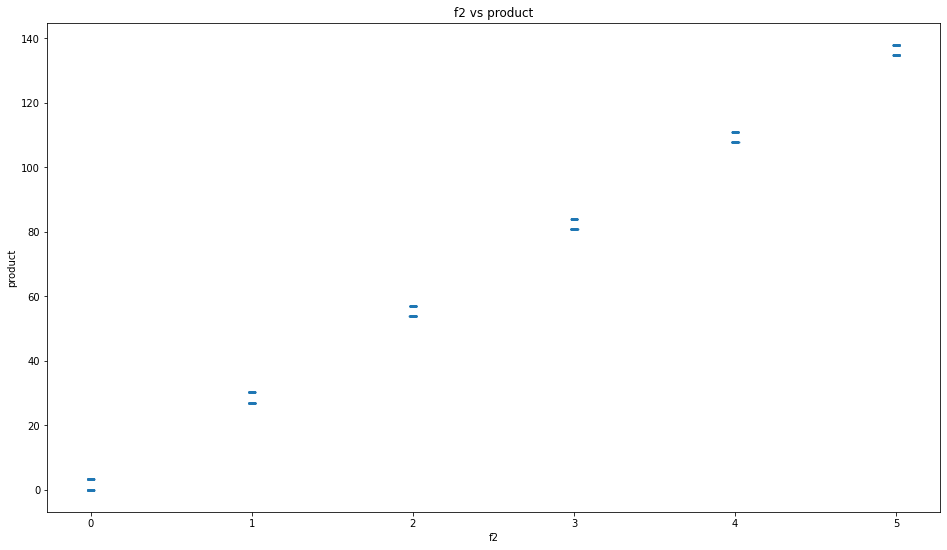




Корреляционный анализ данных


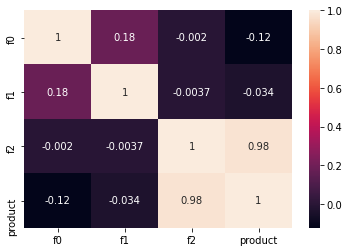

In [5]:
# Анализ df1
full_an(df1)

Вывод датасетов


id        f0        f1        f2     product
13355  TefZ7 -0.175770 -0.146715  5.465704  127.371234
78095  eZmuN -3.047430  0.658567  0.642463   87.432041
65397  7JM4C -0.202454  3.893107 -1.784595   50.798660
13282  ErjFF  0.195328  1.068043  2.418868    0.508937
57035  zu5gG -1.662932 -1.252037  0.497127  151.324240

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None




Предподготовка данных
Количество полных дубликатов в датасете: 0

Количество неполных дубликатов в датасете: 0

Количество пропусков в датасете:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64




Исследовательский анализ данных


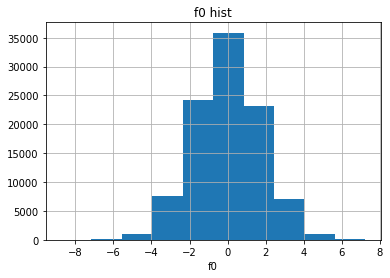

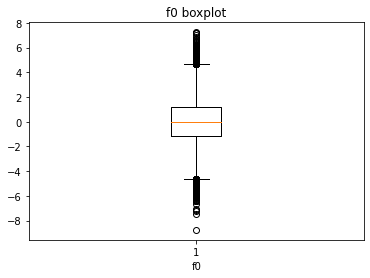

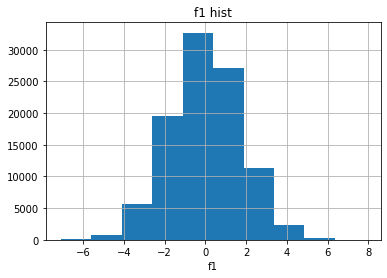

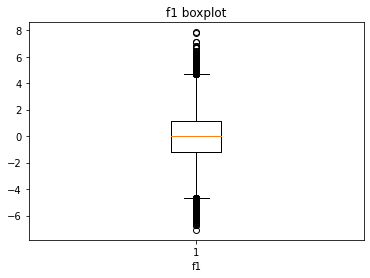

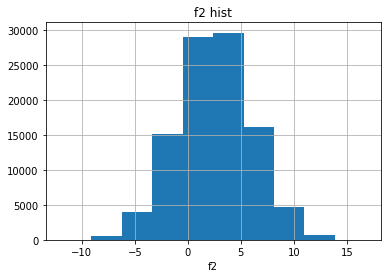

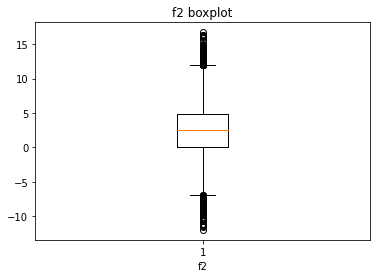

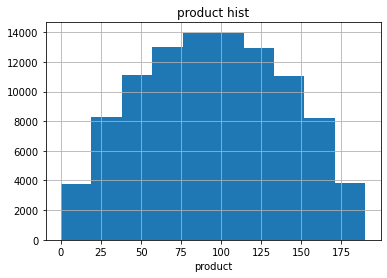

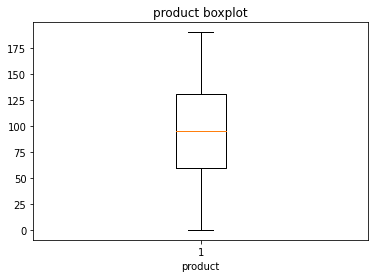




Диаграммы рассеяния


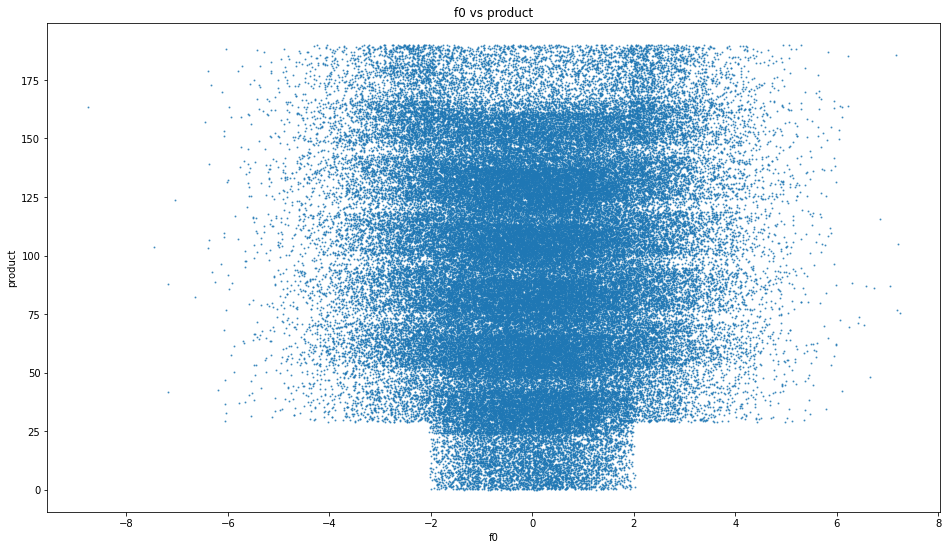

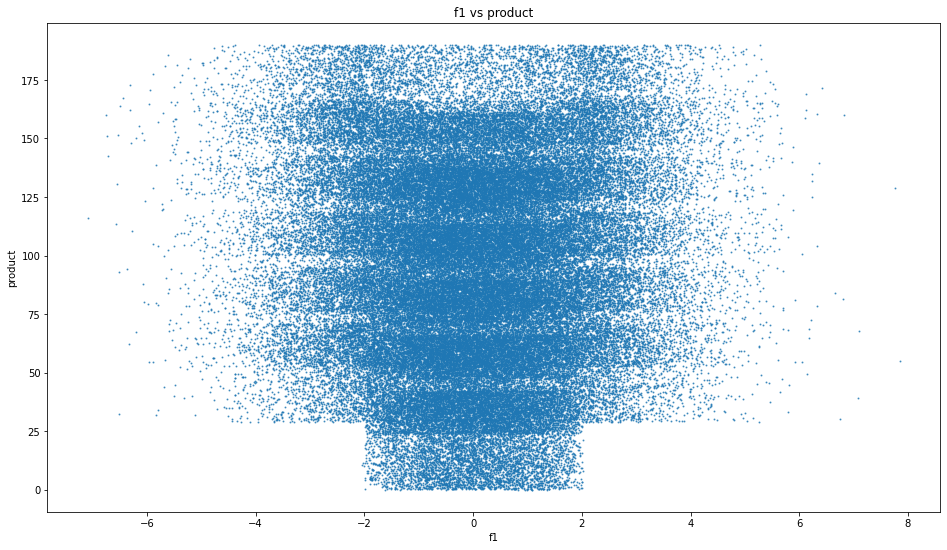

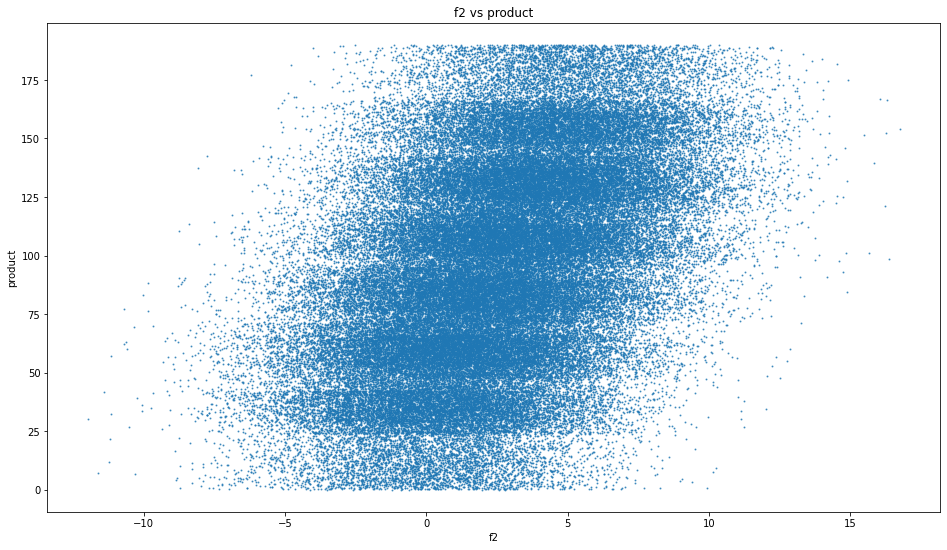




Корреляционный анализ данных


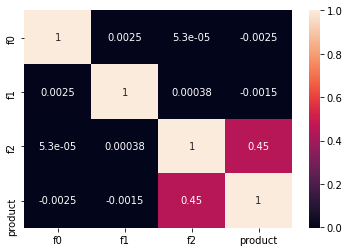

In [6]:
# Анализ df2
full_an(df2)

### Выводы 
Данные не содержат ошибок, пропусков, выбросов.

Замечены резкие границы во входных параметрах f1, f0. 

Также замечена крайне малая дисперсия в данных df1 и большое количество объектов с очень низким и очень высоким параметром product. 
Кроме того, параметры f2 и параметр product датасета df1 имеют коэффициент корреляции 0.98, тогда как f2 и product других датасетов имеют коэффициент корреляции около 0.5.

## Обучение и проверка модели

In [7]:
df0 = df0.set_index('id')
df1 = df1.set_index('id')
df2 = df2.set_index('id')

In [8]:
# Функция обучения линейной модели регрессии

RANDOM_STATE = 42
def fitter(df):
    X = df.drop('product', axis = 1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    model = LinearRegression()
    X_train_sc = scaler.fit_transform(X_train)
    X_valid_sc = scaler.transform(X_valid)
    model.fit(X_train_sc, y_train)
    y_pred = model.predict(X_valid_sc)
    print('RMSE', mean_squared_error(y_valid, y_pred, squared = False))
    print('Средний предсказанный запас:', np.mean(y_pred))
    print('Средний настоящий запас:', np.mean(y_valid))
    y_pred = pd.DataFrame(y_pred).set_index(X_valid.index)
    y_pred['product_true'] = y_valid
    y_pred.columns = ['product_pred', 'product_true']
    return scaler, model, y_pred

Результаты предсказания по df0
RMSE 37.75660035026169
Средний предсказанный запас: 92.39879990657768
Средний настоящий запас: 92.32595637084387


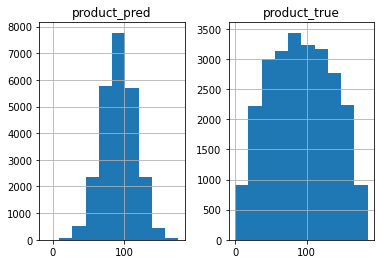


Результаты предсказания по df1
RMSE 0.8902801001028846
Средний предсказанный запас: 68.7128780391376
Средний настоящий запас: 68.72538074722745


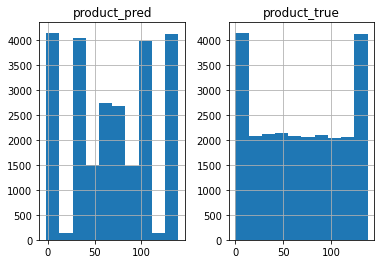


Результаты предсказания по df2
RMSE 40.145872311342174
Средний предсказанный запас: 94.77102387765939
Средний настоящий запас: 95.15099907171961


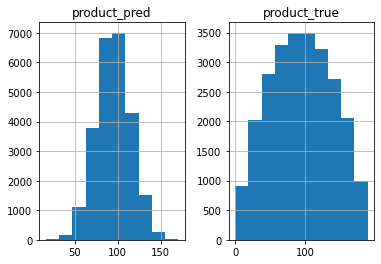

In [9]:
# Получаем предсказания для датасета каждого региона

print('Результаты предсказания по df0')
scaler_df0, model_df0, y_pred_df0 = fitter(df0)
y_pred_df0.hist()
plt.show()
print()

print('Результаты предсказания по df1')
scaler_df1, model_df1, y_pred_df1 = fitter(df1)
y_pred_df1.hist()
plt.show()
print()

print('Результаты предсказания по df2')
scaler_df2, model_df2, y_pred_df2 = fitter(df2)
y_pred_df2.hist()
plt.show()
print()

### Выводы

Результаты моделирования показали ожидаемую картину: 
- датасет df1 имеет очень высокий коэффициент корреляции (0.98) между входным признаком f2 и выходным признаком product и демонстрирует крайне низкий rmse.
- датасеты df0 и df2 имеют среднюю корреляцию (0.45) между f2 и product, но при этом высокую дисперсию, что вызывает высокую степень совпадения средних предсказаний и истиных значений, но высокую дисперсию результатов (rmse). 

Поскольку нас в первую очередь интересуют результаты в среднем по региону, а не по каждой отдельной скажине, это допустимо.

Также замечены отрицательные значения product, что нереально, но не повлияет на дальнейшее исследование.




## Подготовка к расчёту прибыли

In [10]:
investment_region = 10*10**(9)
income_per_product = 450*10**(3)
volume_region = investment_region / income_per_product
number_bore = 200
product_bore = volume_region / number_bore
print('Средняя необходимая для безубыточности выработка каждой из 200 лучших скважин в регионе равна', int(product_bore//1))

Средняя необходимая для безубыточности выработка каждой из 200 лучших скважин в регионе равна 111


### Выводы
Для выхода на безубыточность (необходимые инвестиции в регион на открытие 200 лучших скважин в 10 млрд рублей окупаются доходом от скважин) необходимо, чтобы в среднем каждая из открытых скважин приносила более 111 тысяч баррелей. Это значение выше средних по регионам, т.е. необходимо внимательно отнестись к отбору лучших скважин в каждом из регионов, чтобы достичь безубыточности. 

## Расчёт прибыли и рисков 

In [11]:
# Функция отбирает 200 скважин с лучшими прогнозами, находит сумму их истиных объемов выработки и находит их прибыль

def income_eval(y_pred_df):
    df_best = y_pred_df.sort_values(by = 'product_pred', ascending = False)[:200]
    df_best_sum = df_best['product_pred'].sum()
    income_pred = df_best['product_true'].sum() * income_per_product - 10000000000
    return df_best, df_best_sum, income_pred

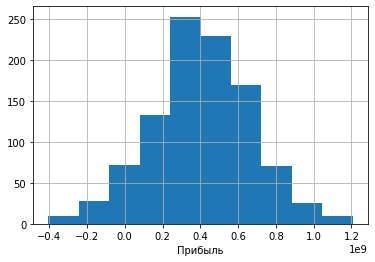

Средняя прибыль 406278783.42441905
95% доверительный интервал -117742136.49486831 : 911737050.7514055
Вероятность убытков - 6.7%


In [12]:
# При помощи bootstrap 1000 раз отбираем по 500 выборок из валидационной выборки региона df0 
# и с помощью функции income_eval оцениваем их прибыльность

state = np.random.RandomState(12345)

values = []
for i in range(1000):
    subsample = y_pred_df0.sample(n=500, replace=True, random_state=state)
    values.append(income_eval(subsample)[2])

values = pd.Series(values)
plt.figure()
values.hist()
plt.xlabel('Прибыль')
plt.show()

print('Средняя прибыль', values.mean())
    
lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('95% доверительный интервал', lower, ':', upper)

risk = st.percentileofscore(values, 0)

print(f'Вероятность убытков - {risk}%')

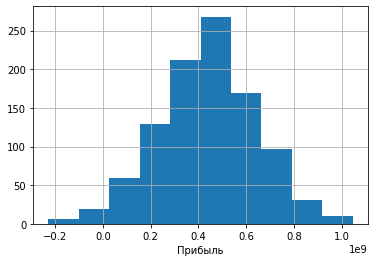

Средняя прибыль 441504277.5922549
95% доверительный интервал 35728489.280851334 : 828006639.0043902
Вероятность убытков - 1.6%


In [13]:
# При помощи bootstrap 1000 раз отбираем по 500 выборок из валидационной выборки региона df1 
# и с помощью функции income_eval оцениваем их прибыльность

values = []
for i in range(1000):
    subsample = y_pred_df1.sample(n=500, replace=True, random_state=state)
    values.append(income_eval(subsample)[2])

values = pd.Series(values)
plt.figure()
values.hist()
plt.xlabel('Прибыль')
plt.show()

print('Средняя прибыль', values.mean())
    
lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('95% доверительный интервал', lower, ':', upper)

risk = st.percentileofscore(values, 0)

print(f'Вероятность убытков - {risk}%')

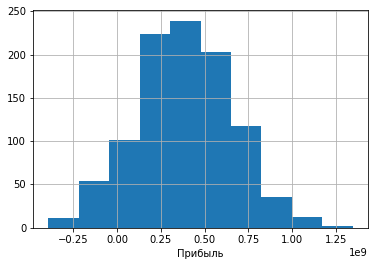

Средняя прибыль 385213195.91415244
95% доверительный интервал -164785166.1090443 : 888206234.1976783
Вероятность убытков - 7.800000000000001%


In [14]:
# При помощи bootstrap 1000 раз отбираем по 500 выборок из валидационной выборки региона df2 
# и с помощью функции income_eval оцениваем их прибыльность

values = []
for i in range(1000):
    subsample = y_pred_df2.sample(n=500, replace=True, random_state=state)
    values.append(income_eval(subsample)[2])

values = pd.Series(values)
plt.figure()
values.hist()
plt.xlabel('Прибыль')
plt.show()

print('Средняя прибыль', values.mean())
    
lower = values.quantile(0.025)
upper = values.quantile(0.975)

print('95% доверительный интервал', lower, ':', upper)

risk = st.percentileofscore(values, 0)

print(f'Вероятность убытков - {risk}%')

### Выводы

Найдены средние значения прибылей, доверительные интервалы и риск убыточности для каждого из регионов.


df0: 
- Средняя прибыль 406278783.42441905
- 95% доверительный интервал -117742136.49486831 : 911737050.7514055
- Вероятность убытков - 6.7%

df1:
- Средняя прибыль 441504277.5922549
- 95% доверительный интервал 35728489.280851334 : 828006639.0043902
- Вероятность убытков - 1.6%

df2:
- Средняя прибыль 385213195.91415244
- 95% доверительный интервал -164785166.1090443 : 888206234.1976783
- Вероятность убытков - 7.800000000000001%


Регион df2 имеет наибольшую ожидаемую прибыль и подходящий уровень риска убытков (1.6% меньше 2.5%) и должен быть выбран для разработки скважин.

## Выводы

Получены и исследованы данные по месторождениям 3 регионов.

Построены модели, предсказывающая объем выработки месторождения в регионах, и получены метрики их работы. 

Построена функция расчета суммарной прибыли 200 лучших месторождений региона.

При помощи bootstrap получены средние значения прибыли, 95% доверительные интервалы и вероятности убытков каждого из регионов. 

Регион df2 соответствует всем требованиям и должен быть рассмотрен к разработке.